Testing:
- Did I do the trimming to UK mask thing?

In [1]:
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import iris.plot as iplt

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
##################################################################

# Constraint to only load JJA data
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)


In [2]:
### Establish the ensemble members
ems = ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15']
em = '01'


In [3]:
yrs_range = "1980_2001"
resolution = '2.2km' #2.2km, 12km, 2.2km_regridded_12km
ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/leeds-at-centre/{em}/"

print(em, resolution, trim_to_leeds)

# ### Get a list of filenames for this ensemble member, for just JJA
if resolution == '2.2km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_*'
elif resolution == '12km':
      general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
elif resolution == '2.2km_regridded_12km':
    general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_*'

filenames = []
for filename in sir_globington_the_file_gatherer.glob(general_filename):
    filenames.append(filename)
print(len(filenames))

# ### Load in the data
monthly_cubes_list = iris.load(filenames, in_jja)

for cube in monthly_cubes_list:
     for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
            if attr in cube.attributes:
                del cube.attributes[attr]

# ### Concatenate cubes into one
model_cube = monthly_cubes_list.concatenate_cube()      

### Remove ensemble member dimension
model_cube = model_cube[0,:,:,:]

01 2.2km False
62


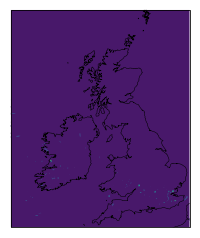

In [9]:
cube_jja_uk = trim_to_bbox_of_region_regriddedobs(model_cube, uk_gdf)

iplt.contourf(cube_jja_uk[10])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [10]:
print("getting mask")
lsm = iris.load("/nfs/a319/gy17m2a/PhD/datadir/lsm_land-cpm_BI_5km.nc")
lsm = lsm[0]
lsm_nn =lsm.regrid(cube_jja_uk, iris.analysis.Nearest())   

getting mask


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/iris/coord_systems.py:531: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  globe=globe,


In [11]:
# Convert to shape of cube
broadcasted_lsm_data = np.broadcast_to(lsm_nn.data.data, cube_jja_uk.shape)
# # Convert to integer
# broadcasted_lsm_data_int = broadcasted_lsm_data.astype(int)
# Reverse the array (it is the opposite way round to the exisitng val/no val mask on the radar data)
reversed_array = ~broadcasted_lsm_data.astype(bool)

In [12]:
land_mask = np.where(lsm_nn.data > 0, True, False)
broadcasted_lsm_data = np.broadcast_to(land_mask, cube_jja_uk.shape)
lsm_cube = cube_jja_uk.copy(data=broadcasted_lsm_data)

In [ ]:
masked_cube = iris.util.mask_cube(cube_jja_uk, reversed_array)

In [ ]:
iplt.contourf(masked_cube[0])
plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

In [ ]:
ddir + f'maskedcube.nc'
iris.save(masked_cube, ddir + f'maskedcube.nc')

In [ ]:
print(f"Min value is {np.nanmin(masked_cube.data)}")

In [ ]:
# Get rid of negative values
compressed = masked_cube.data.compressed()
compressed.shape[0]
np.save(ddir + f'compressed.npy', compressed) 